# 🐱🐶 Cat vs Dog Image Classification

This project builds an image classifier to distinguish between cats and dogs using a Convolutional Neural Network (CNN) with transfer learning (MobileNetV2).


In [1]:
import zipfile
import os

zip_path = "/content/catdog.zip"
extract_path = "/content/catdog_dataset"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Show what was extracted
print("Extracted folders:", os.listdir(extract_path))


Extracted folders: ['kagglecatsanddogs_3367a']


In [2]:
import os

base_dir = "/content/catdog_dataset/kagglecatsanddogs_3367a/PetImages"

cat_dir = os.path.join(base_dir, "Cat")
dog_dir = os.path.join(base_dir, "Dog")

print("Number of Cat images:", len(os.listdir(cat_dir)))
print("Number of Dog images:", len(os.listdir(dog_dir)))

print("\nExample Cat files:", os.listdir(cat_dir)[:5])
print("Example Dog files:", os.listdir(dog_dir)[:5])


Number of Cat images: 12491
Number of Dog images: 12470

Example Cat files: ['4063.jpg', '5364.jpg', '6551.jpg', '5160.jpg', '1137.jpg']
Example Dog files: ['4063.jpg', '5364.jpg', '6551.jpg', '5160.jpg', '1137.jpg']


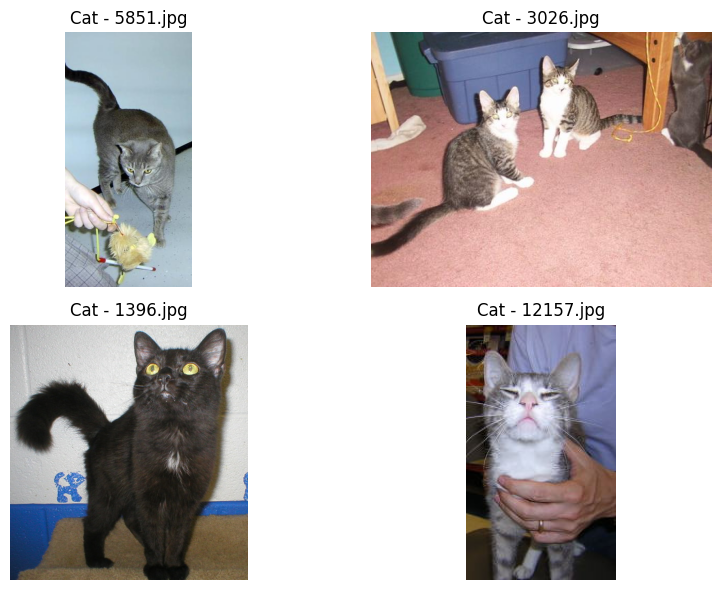

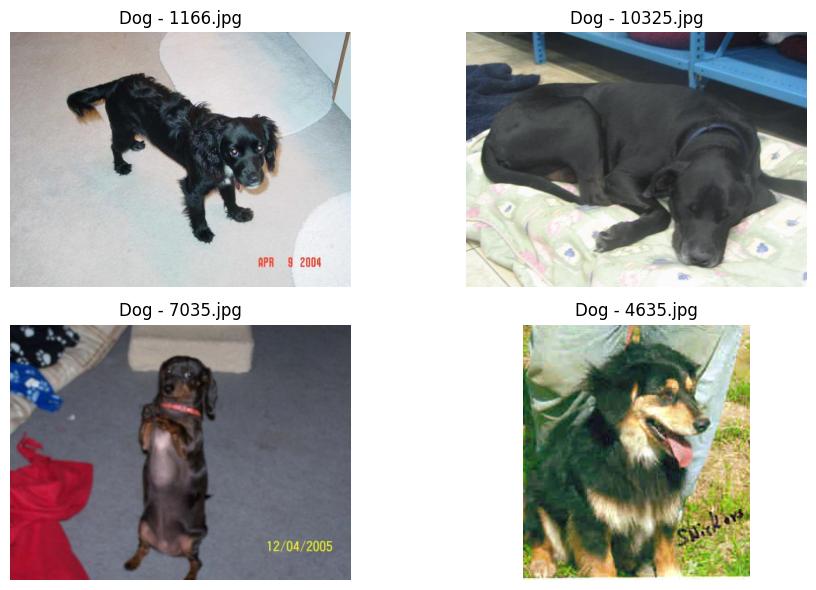

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

cat_dir = "/content/catdog_dataset/kagglecatsanddogs_3367a/PetImages/Cat"
dog_dir = "/content/catdog_dataset/kagglecatsanddogs_3367a/PetImages/Dog"

def show_random_images(folder, title):
    files = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    sample_files = random.sample(files, 4)

    plt.figure(figsize=(10, 6))
    for i, img_file in enumerate(sample_files):
        try:
            img_path = os.path.join(folder, img_file)
            img = mpimg.imread(img_path)
            plt.subplot(2, 2, i + 1)
            plt.imshow(img)
            plt.title(f"{title} - {img_file}")
            plt.axis('off')
        except:
            continue
    plt.tight_layout()
    plt.show()

show_random_images(cat_dir, "Cat")
show_random_images(dog_dir, "Dog")


In [4]:
from PIL import Image

def get_image_sizes(folder):
    sizes = []
    for fname in os.listdir(folder)[:100]:  # Check first 100
        if fname.lower().endswith('.jpg'):
            try:
                img = Image.open(os.path.join(folder, fname))
                sizes.append(img.size)
            except:
                pass  # Skip corrupted
    return sizes

cat_sizes = get_image_sizes(cat_dir)
dog_sizes = get_image_sizes(dog_dir)

print("Sample Cat Image Sizes:", cat_sizes[:5])
print("Sample Dog Image Sizes:", dog_sizes[:5])


Sample Cat Image Sizes: [(400, 272), (405, 349), (500, 459), (450, 450), (355, 500)]
Sample Dog Image Sizes: [(400, 241), (470, 500), (500, 337), (380, 353), (500, 375)]


In [5]:
num_cats = len([f for f in os.listdir(cat_dir) if f.lower().endswith('.jpg')])
num_dogs = len([f for f in os.listdir(dog_dir) if f.lower().endswith('.jpg')])

print("Total Cat Images:", num_cats)
print("Total Dog Images:", num_dogs)


Total Cat Images: 12490
Total Dog Images: 12469


In [6]:
import os, shutil, random
from PIL import Image

# Original dataset
original_dir = "/content/catdog_dataset/kagglecatsanddogs_3367a/PetImages"
cat_dir = os.path.join(original_dir, "Cat")
dog_dir = os.path.join(original_dir, "Dog")

# New clean structure
base_dir = "/content/catdog_cleaned"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# Create subfolders
for split in ['train', 'validation']:
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Clean, verify, split
def clean_and_copy(src_folder, category):
    all_images = [f for f in os.listdir(src_folder) if f.lower().endswith('.jpg')]
    random.shuffle(all_images)
    split_idx = int(len(all_images) * 0.8)

    train_files = all_images[:split_idx]
    val_files = all_images[split_idx:]

    for phase, file_list in [('train', train_files), ('validation', val_files)]:
        for fname in file_list:
            src = os.path.join(src_folder, fname)
            dst = os.path.join(base_dir, phase, category, fname)
            try:
                img = Image.open(src)
                img.verify()  # Check for corruption
                shutil.copy(src, dst)
            except:
                continue

clean_and_copy(cat_dir, "cats")
clean_and_copy(dog_dir, "dogs")

print("✅ Cleaning and splitting complete.")


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


✅ Cleaning and splitting complete.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training: Normalize + Augment
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

# Validation: Only Normalize
val_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

validation_generator = val_gen.flow_from_directory(
    os.path.join(base_dir, "validation"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.


##  Data Preprocessed
- Removed corrupted files
- Split into training (80%) and validation (20%)
- Resized all images to 224x224
- Normalized pixel values from [0, 255] to [0, 1]
- Augmented training images (rotation, flip, zoom, brightness)


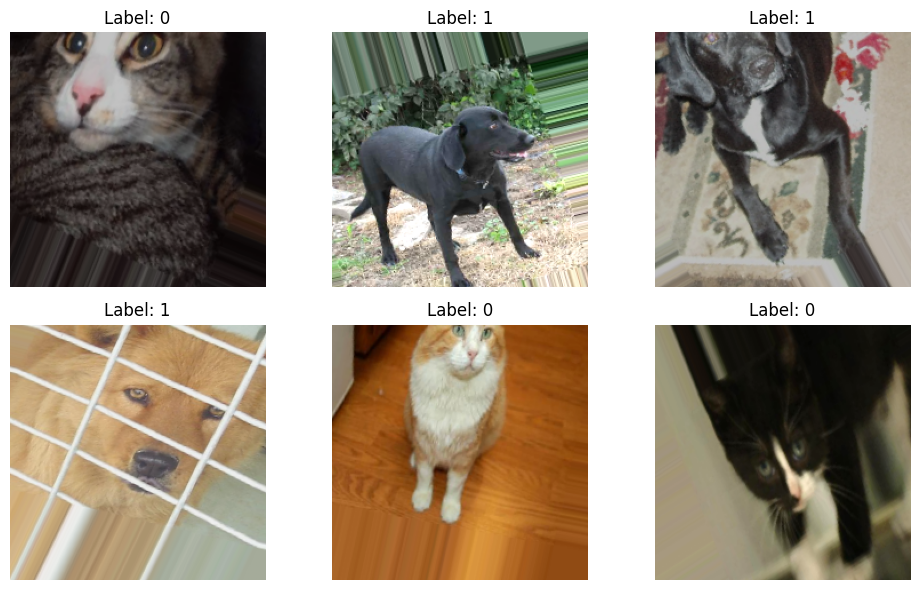

In [8]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Model

- Pre-trained MobileNetV2

why ?
- Lightweight and accurate
- Trained on ImageNet
- Ideal for real-time apps


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2


In [10]:
IMG_SHAPE = (224, 224, 3)

# Load MobileNetV2 without top layer
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,  # No classification head
                         weights='imagenet')

# Freeze base model layers
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),         # Reduce tensor size
    layers.Dropout(0.2),                     # Prevent overfitting
    layers.Dense(1, activation='sigmoid')    # Binary output: cat or dog
])


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
EPOCHS = 5

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9144 - loss: 0.2111

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.9145 - loss: 0.2110 - val_accuracy: 0.9776 - val_loss: 0.0559
Epoch 2/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - accuracy: 0.9633 - loss: 0.0965 - val_accuracy: 0.9802 - val_loss: 0.0513
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - accuracy: 0.9655 - loss: 0.0841 - val_accuracy: 0.9810 - val_loss: 0.0491
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 933s 1s/step - accuracy: 0.9674 - loss: 0.0840 - val_accuracy: 0.9768 - val_loss: 0.0574
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 795s 1s/step - accuracy: 0.9677 - loss: 0.0840 - val_accuracy: 0.9828 - val_loss: 0.0455


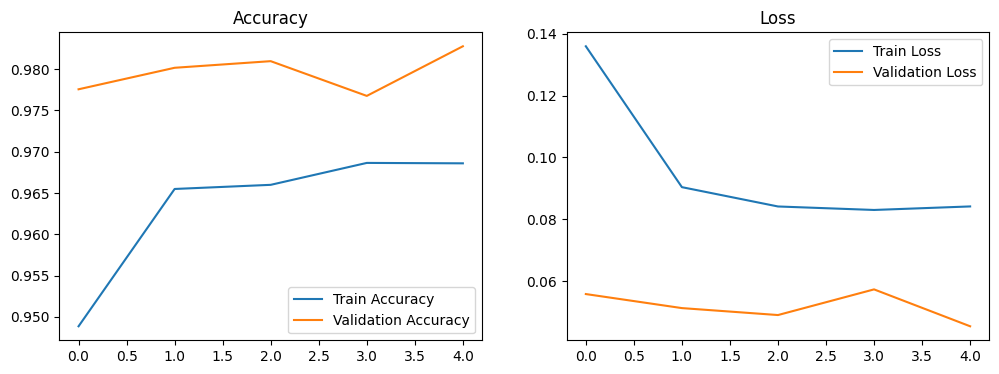

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


## Model Trained

- Trained for 5 epochs


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

##  Model Evaluation

- Confusion matrix
- Classification report (Precision, Recall, F1-Score)
- Misclassified image visualization
- Confidence score analysis


In [17]:
# Make predictions on validation data
val_steps = validation_generator.samples // validation_generator.batch_size + 1

# Get model predictions
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_labels = (y_pred > 0.5).astype("int32").flatten()

# True labels
y_true = validation_generator.classes


157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 757ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [18]:
print(classification_report(y_true, y_pred_labels, target_names=['Cat', 'Dog']))


              precision    recall  f1-score   support

         Cat       0.49      0.48      0.49      2498
         Dog       0.49      0.50      0.50      2494

    accuracy                           0.49      4992
   macro avg       0.49      0.49      0.49      4992
weighted avg       0.49      0.49      0.49      4992



<Figure size 600x600 with 0 Axes>

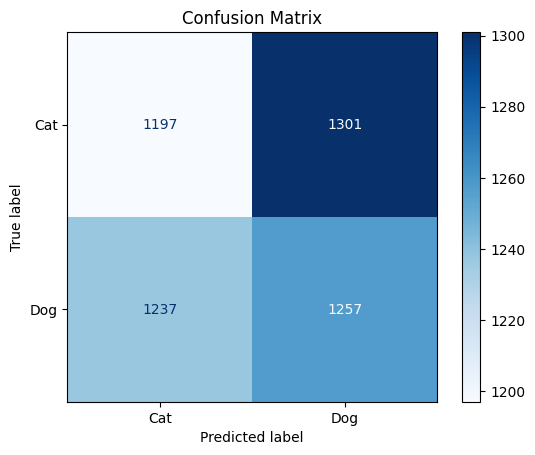

In [19]:
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 ━━━━━━━━━━━━━━━━━━━━ 114s 719ms/step


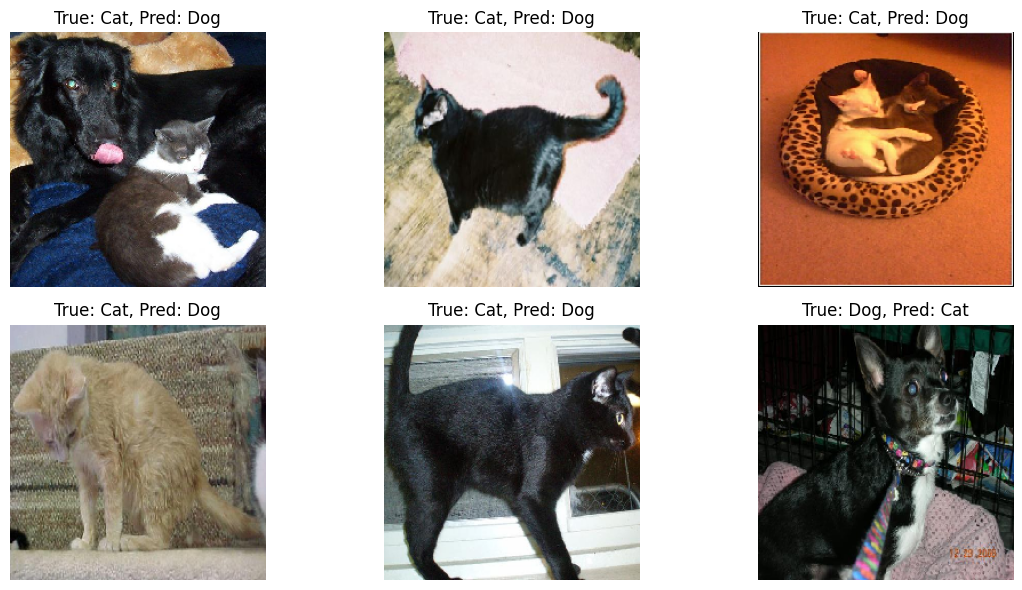

In [21]:
# Reset and collect all validation images
import numpy as np

validation_generator.reset()
x_val, y_val = next(validation_generator)
for _ in range(val_steps - 1):
    x_batch, y_batch = next(validation_generator)
    x_val = np.concatenate((x_val, x_batch))
    y_val = np.concatenate((y_val, y_batch))

# Make predictions again
pred_probs = model.predict(x_val)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Misclassified indexes
misclassified = np.where(pred_labels != y_val)[0]

# Show first 6 misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_val[idx])
    true = "Cat" if y_val[idx] == 0 else "Dog"
    pred = "Cat" if pred_labels[idx] == 0 else "Dog"
    plt.title(f"True: {true}, Pred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [22]:
# Show confidence of misclassified images
for idx in misclassified[:5]:
    confidence = pred_probs[idx][0]
    print(f"Predicted: {pred_labels[idx]} | True: {int(y_val[idx])} | Confidence: {confidence:.2f}")


Predicted: 1 | True: 0 | Confidence: 0.91
Predicted: 1 | True: 0 | Confidence: 0.85
Predicted: 1 | True: 0 | Confidence: 0.61
Predicted: 1 | True: 0 | Confidence: 0.58
Predicted: 1 | True: 0 | Confidence: 0.98


Custom Input

- Uploaded custom image using Colab file upload
- Preprocessed the image manually
- Displayed prediction (Cat or Dog) and confidence score

In [23]:
from google.colab import files
uploaded = files.upload()


Saving cat.jpg to cat.jpg


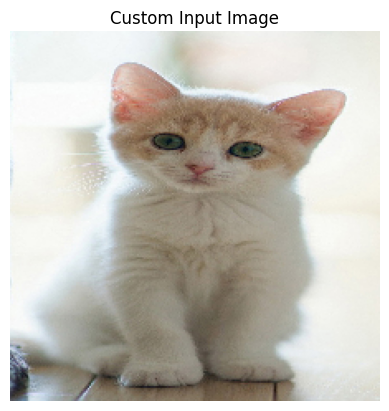

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Change this if your uploaded file has a different name
img_path = list(uploaded.keys())[0]

# Load image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Show the image
plt.imshow(img)
plt.axis('off')
plt.title("Custom Input Image")
plt.show()


In [25]:
pred_prob = model.predict(img_batch)[0][0]
pred_label = "Dog" if pred_prob > 0.5 else "Cat"
confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

print(f"Predicted: {pred_label}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: Cat
Confidence: 1.00


In [26]:
model.save("catdog_model.h5")

saved the model  as catdog_model